# Загрузка датасета + предобработка

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import transformers
from datasets import Dataset


from tqdm import tqdm


import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,SnowballStemmer

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

d:\ВУЗ\МАГА\3 семместр\Нейронные сети и глубокое обучение\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zotov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zotov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zotov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zotov\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloadin

True

In [2]:
imdb=pd.read_csv('./IMDB Dataset.csv')
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
def remove_html_tag(text):
  reg = re.compile('<.*?>')
  return reg.sub(r'', text)

def remove_punctuation_marks(text):
  reg = re.compile('[^0-9a-zA-Z-'' ]')
  return reg.sub(r'', text)

stop_words= set(stopwords.words('english'))
def delete_stop_word(text):
  return [word for word in word_tokenize(text) if word not in stop_words]

def colomn_unite(text):
  return ' '.join(text)

In [4]:
imdb['review'] = imdb['review'].str.lower()
imdb['review'] = imdb['review'].apply(remove_html_tag)
imdb['review'] = imdb['review'].apply(remove_punctuation_marks)
imdb['review'] = imdb['review'].apply(delete_stop_word)
imdb['review'] = imdb['review'].apply(colomn_unite)
imdb = imdb.rename(columns={'review': 'text', })
imdb['labels'] = imdb['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

imdb.head(10)

,text,sentiment,labels
0,one reviewers mentioned watching 1 oz episode ...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically theres family little boy jake thinks...,negative,0
4,petter matteis love time money visually stunni...,positive,1
5,probably all-time favorite movie story selfles...,positive,1
6,sure would like see resurrection dated seahunt...,positive,1
7,show amazing fresh innovative idea 70s first a...,negative,0
8,encouraged positive comments film looking forw...,negative,0
9,like original gut wrenching laughter like movi...,positive,1


# Baseline(логистическая регрессия + TF-IDF)

In [5]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(imdb['text'])
X_train_tfidf , X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, imdb['labels'], test_size=0.2, random_state=42)

baseline_clf = LogisticRegression(max_iter=1000)
baseline_clf.fit(X_train_tfidf, y_train)

y_pred_baseline = baseline_clf.predict(X_test_tfidf)
acc_baseline = accuracy_score(y_test, y_pred_baseline)
cm_baseline  = confusion_matrix(y_test, y_pred_baseline)
print("Baseline accuracy:", acc_baseline)
print("Baseline confusion matrix:\n", cm_baseline)

Baseline accuracy: 0.8963
Baseline confusion matrix:
 [[4380  581]
 [ 456 4583]]


# BERT (через HuggingFace)

In [6]:
train_df, test_df = train_test_split(imdb, test_size=0.2, random_state=42, stratify=imdb['labels'])

# Преобразование в Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['text', 'labels']])

In [7]:
# Токенизатор и модель
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Функция токенизации
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Токенизация (batched для эффективности)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 10000/10000 [00:12<00:00, 798.15 examples/s]


Epoch,Training Loss,Validation Loss,Accuracy
1,0.251800,0.233327,0.915400
2,0.176900,0.287074,0.916000
3,0.094000,0.338880,0.925100


BERT Accuracy: 0.9251


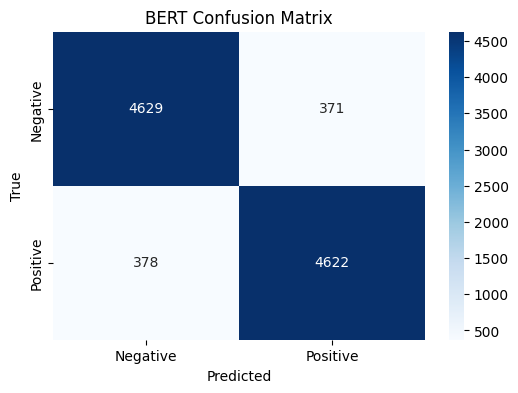

In [8]:
# Установка формата для PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])



# Аргументы обучения
training_args = TrainingArguments(
    output_dir='./results', #директория куда сохраняются чекпоины модели
    num_train_epochs=3, #количество эпох
    per_device_train_batch_size=16, #размер батча на обучении
    per_device_eval_batch_size=16, #размер батча на валидации
    learning_rate=2e-5,
    warmup_steps=500, #штука которая доводит learning rate с 0 до заданого или дефолта
    weight_decay=0.01, #коэффициент L2-регуляризации
    logging_dir='./logs',
    metric_for_best_model='accuracy',#метрика по оценке моделей
    greater_is_better=True,#больше лучше
    eval_strategy="epoch", #стратегия оценки модели, в нашем случае в конце эпохи
    save_strategy="epoch", #стратегия сохранения модели, как и в случае с оценкой
    load_best_model_at_end=True #загрузка лучшей модели после обучения
)

# Функция для метрик
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Трейнер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tuning
trainer.train()

# Оценка
results = trainer.evaluate()
print(f"BERT Accuracy: {results['eval_accuracy']}")

# Confusion Matrix (после оценки)
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()

Выводы:
1. Точность BERT лучше. Особенно лучше не предсказываются FN. Одна из причин, почему baseline хуже - она не учитывает контекст и порядок слов.
2. Из интересного, val loss на обучение увеличивается, это говорит о том, что модель переобучается (training loss падает), но при этом точность растет.
3. Ну и хотя BERT лучше baseline на 3%, но обучалась она на ~50 минут дольше.